# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 680us/step - loss: 0.8306 - accuracy: 0.6984
Epoch 2/50
180/180 [==============================] - 0s 661us/step - loss: 0.2889 - accuracy: 0.8809
Epoch 3/50
180/180 [==============================] - 0s 739us/step - loss: 0.2051 - accuracy: 0.9199
Epoch 4/50
180/180 [==============================] - 0s 597us/step - loss: 0.1550 - accuracy: 0.9432
Epoch 5/50
180/180 [==============================] - 0s 583us/step - loss: 0.1364 - accuracy: 0.9444
Epoch 6/50
180/180 [==============================] - 0s 606us/step - loss: 0.1115 - accuracy: 0.9566
Epoch 7/50
180/180 [==============================] - 0s 614us/step - loss: 0.0993 - accuracy: 0.9616
Epoch 8/50
180/180 [==============================] - 0s 654us/step - loss: 0.0871 - accuracy: 0.9677
Epoch 9/50
180/180 [==============================] - 0s 622us/step - loss: 0.0809 - accuracy: 0.9694
Epoch 10/50
180/180 [==============================] - 0s 621us/step - loss: 0.075

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [5]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 667us/step - loss: 0.9127 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 712us/step - loss: 0.8701 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 777us/step - loss: 0.8355 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 759us/step - loss: 0.8061 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 709us/step - loss: 0.7825 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 736us/step - loss: 0.7634 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 699us/step - loss: 0.7485 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 739us/step - loss: 0.7363 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 724us/step - loss: 0.7270 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 795us/step - loss: 0.7190 - accuracy: 0.4961

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [6]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fde1726fca0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.9126896858215332,
   0.8701481223106384,
   0.8354955911636353,
   0.806090772151947,
   0.7824792265892029,
   0.7634244561195374,
   0.7484851479530334,
   0.7363371253013611,
   0.7269832491874695,
   0.7190151214599609],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

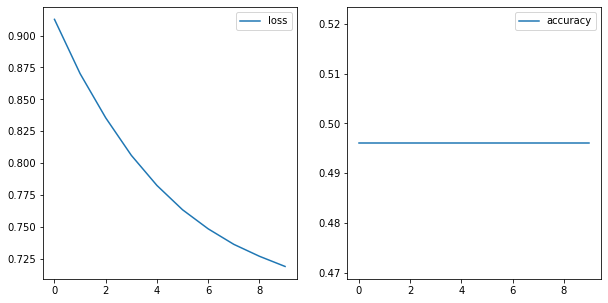

In [7]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [ ]:
X_pure_train.shape[0]

In [8]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=50, verbose=1)

Epoch 1/100
23/23 [==============================] - 0s 646us/step - loss: 0.7260 - accuracy: 0.4970
Epoch 2/100
23/23 [==============================] - 0s 753us/step - loss: 0.7095 - accuracy: 0.5213
Epoch 3/100
23/23 [==============================] - 0s 709us/step - loss: 0.6987 - accuracy: 0.5466
Epoch 4/100
23/23 [==============================] - 0s 747us/step - loss: 0.6896 - accuracy: 0.5753
Epoch 5/100
23/23 [==============================] - 0s 715us/step - loss: 0.6807 - accuracy: 0.5849
Epoch 6/100
23/23 [==============================] - 0s 659us/step - loss: 0.6719 - accuracy: 0.6057
Epoch 7/100
23/23 [==============================] - 0s 711us/step - loss: 0.6629 - accuracy: 0.6223
Epoch 8/100
23/23 [==============================] - 0s 679us/step - loss: 0.6533 - accuracy: 0.6371
Epoch 9/100
23/23 [==============================] - 0s 712us/step - loss: 0.6431 - accuracy: 0.6493
Epoch 10/100
23/23 [==============================] - 0s 678us/step - loss: 0.6322 - accura

23/23 [==============================] - 0s 643us/step - loss: 0.2049 - accuracy: 0.9130
Epoch 82/100
23/23 [==============================] - 0s 705us/step - loss: 0.2033 - accuracy: 0.9121
Epoch 83/100
23/23 [==============================] - 0s 638us/step - loss: 0.2026 - accuracy: 0.9130
Epoch 84/100
23/23 [==============================] - 0s 621us/step - loss: 0.2017 - accuracy: 0.9121
Epoch 85/100
23/23 [==============================] - 0s 613us/step - loss: 0.1997 - accuracy: 0.9121
Epoch 86/100
23/23 [==============================] - 0s 636us/step - loss: 0.1993 - accuracy: 0.9173
Epoch 87/100
23/23 [==============================] - 0s 647us/step - loss: 0.1981 - accuracy: 0.9173
Epoch 88/100
23/23 [==============================] - 0s 725us/step - loss: 0.1976 - accuracy: 0.9156
Epoch 89/100
23/23 [==============================] - 0s 621us/step - loss: 0.1971 - accuracy: 0.9147
Epoch 90/100
23/23 [==============================] - 0s 632us/step - loss: 0.1948 - accuracy: 

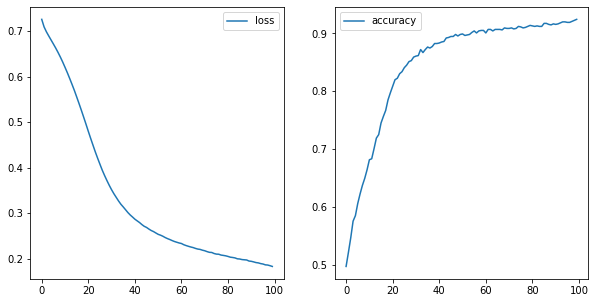

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

In [ ]:
model = Sequential()

sgd = 
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=None,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5466 - val_loss: 0.6345 - val_accuracy: 0.5868
Epoch 2/30
115/115 [==============================] - 0s 935us/step - loss: 0.5664 - accuracy: 0.7276 - val_loss: 0.5192 - val_accuracy: 0.7951
Epoch 3/30
115/115 [==============================] - 0s 992us/step - loss: 0.4482 - accuracy: 0.8642 - val_loss: 0.4032 - val_accuracy: 0.8785
Epoch 4/30
115/115 [==============================] - 0s 992us/step - loss: 0.3208 - accuracy: 0.9164 - val_loss: 0.2525 - val_accuracy: 0.9306
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2048 - accuracy: 0.9339 - val_loss: 0.1658 - val_accuracy: 0.9444
Epoch 6/30
115/115 [==============================] - 0s 988us/step - loss: 0.1548 - accuracy: 0.9452 - val_loss: 0.1412 - val_accuracy: 0.9514
Epoch 7/30
115/115 [==============================] - 0s 934us/step - loss: 0.1265 - accuracy: 0.9556 - val_loss: 0.1437 - val_accuracy: 0.9

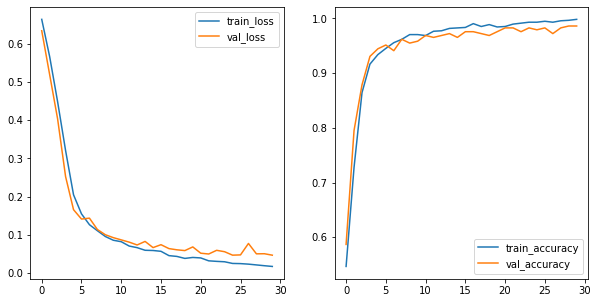

In [10]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, verbose=1, validation_data=(X_val, y_val))


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [11]:
results.history['val_accuracy'][-1]

0.9861111044883728

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [ ]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

In [12]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=1)

In [14]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [15]:
# Can now cross_val
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 [==============================] - 0s 817us/step - loss: 0.7050 - accuracy: 0.4842
Epoch 2/50
29/29 [==============================] - 0s 849us/step - loss: 0.6777 - accuracy: 0.5734
Epoch 3/50
29/29 [==============================] - 0s 796us/step - loss: 0.6528 - accuracy: 0.5985
Epoch 4/50
29/29 [==============================] - 0s 907us/step - loss: 0.6166 - accuracy: 0.7029
Epoch 5/50
29/29 [==============================] - 0s 806us/step - loss: 0.5663 - accuracy: 0.7737
Epoch 6/50
29/29 [==============================] - 0s 781us/step - loss: 0.5052 - accuracy: 0.8477
Epoch 7/50
29/29 [==============================] - 0s 794us/step - loss: 0.4393 - accuracy: 0.8629
Epoch 8/50
29/29 [==============================] - 0s 932us/step - loss: 0.3835 - accuracy: 0.8770
Epoch 9/50
29/29 [==============================] - 0s 719us/step - loss: 0.3252 - accuracy: 0.8999
Epoch 10/50
29/29 [==============================] - 0s 841us/step - loss: 0.2734 - accuracy: 0.9184

29/29 [==============================] - 0s 797us/step - loss: 0.0717 - accuracy: 0.9728
Epoch 32/50
29/29 [==============================] - 0s 822us/step - loss: 0.0759 - accuracy: 0.9728
Epoch 33/50
29/29 [==============================] - 0s 787us/step - loss: 0.0642 - accuracy: 0.9837
Epoch 34/50
29/29 [==============================] - 0s 756us/step - loss: 0.0727 - accuracy: 0.9717
Epoch 35/50
29/29 [==============================] - 0s 751us/step - loss: 0.0630 - accuracy: 0.9793
Epoch 36/50
29/29 [==============================] - 0s 753us/step - loss: 0.0608 - accuracy: 0.9804
Epoch 37/50
29/29 [==============================] - 0s 757us/step - loss: 0.0595 - accuracy: 0.9761
Epoch 38/50
29/29 [==============================] - 0s 795us/step - loss: 0.0553 - accuracy: 0.9837
Epoch 39/50
29/29 [==============================] - 0s 775us/step - loss: 0.0604 - accuracy: 0.9750
Epoch 40/50
29/29 [==============================] - 0s 745us/step - loss: 0.0552 - accuracy: 0.9826
Ep

29/29 [==============================] - 0s 798us/step - loss: 0.4099 - accuracy: 0.8988
Epoch 11/50
29/29 [==============================] - 0s 704us/step - loss: 0.3938 - accuracy: 0.9086
Epoch 12/50
29/29 [==============================] - 0s 771us/step - loss: 0.3809 - accuracy: 0.9129
Epoch 13/50
29/29 [==============================] - 0s 703us/step - loss: 0.3680 - accuracy: 0.9217
Epoch 14/50
29/29 [==============================] - 0s 754us/step - loss: 0.3551 - accuracy: 0.9325
Epoch 15/50
29/29 [==============================] - 0s 752us/step - loss: 0.3450 - accuracy: 0.9369
Epoch 16/50
29/29 [==============================] - 0s 708us/step - loss: 0.3341 - accuracy: 0.9391
Epoch 17/50
29/29 [==============================] - 0s 779us/step - loss: 0.3245 - accuracy: 0.9445
Epoch 18/50
29/29 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.9499
Epoch 19/50
29/29 [==============================] - 0s 829us/step - loss: 0.3081 - accuracy: 0.9510
Epoc

29/29 [==============================] - 0s 757us/step - loss: 0.1078 - accuracy: 0.9533
Epoch 41/50
29/29 [==============================] - 0s 721us/step - loss: 0.1020 - accuracy: 0.9598
Epoch 42/50
29/29 [==============================] - 0s 745us/step - loss: 0.0988 - accuracy: 0.9630
Epoch 43/50
29/29 [==============================] - 0s 733us/step - loss: 0.0951 - accuracy: 0.9652
Epoch 44/50
29/29 [==============================] - 0s 762us/step - loss: 0.0917 - accuracy: 0.9685
Epoch 45/50
29/29 [==============================] - 0s 737us/step - loss: 0.0890 - accuracy: 0.9696
Epoch 46/50
29/29 [==============================] - 0s 754us/step - loss: 0.0841 - accuracy: 0.9717
Epoch 47/50
29/29 [==============================] - 0s 774us/step - loss: 0.0807 - accuracy: 0.9696
Epoch 48/50
29/29 [==============================] - 0s 746us/step - loss: 0.0763 - accuracy: 0.9707
Epoch 49/50
29/29 [==============================] - 0s 739us/step - loss: 0.0732 - accuracy: 0.9728
Ep

array([0.95652175, 0.95652175, 0.97391301, 0.97391301, 0.91703057])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

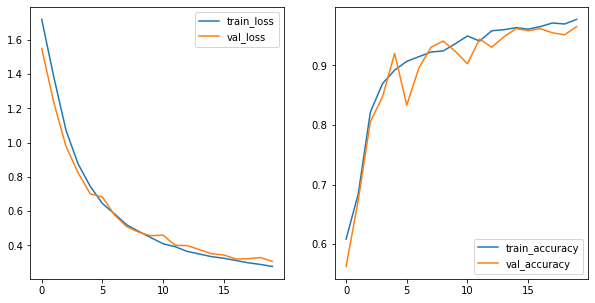

In [17]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

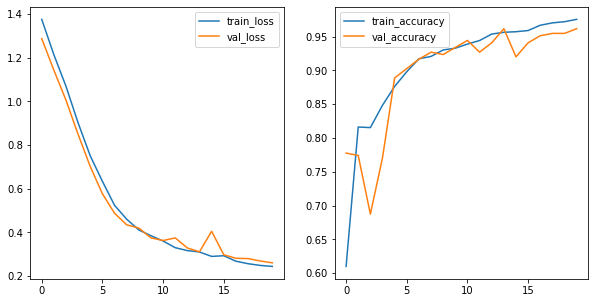

In [18]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

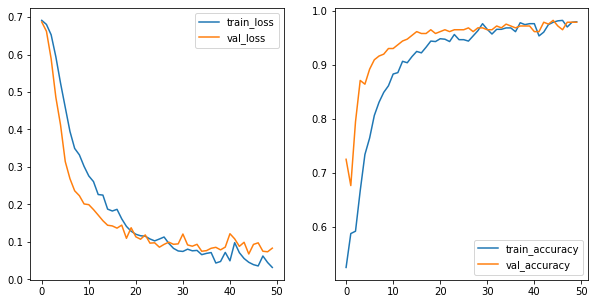

In [19]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.50))
model.add(Dense(12, activation='relu'))
model.add(Dropout(.50))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00010: early stopping


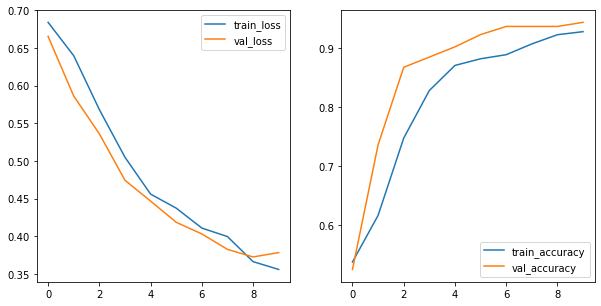

In [20]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00044: early stopping


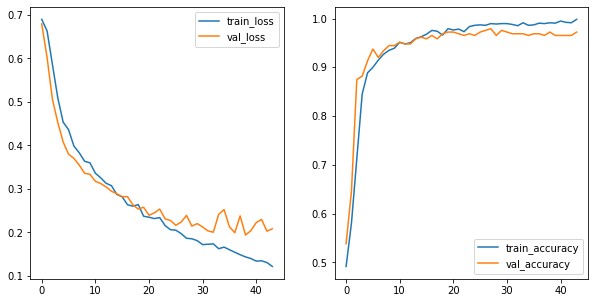

In [21]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [22]:
digits = load_digits()
X = digits.data
y = digits.target

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [24]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [25]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# Final layer will look different need a node for each class
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 2.1557 - accuracy: 0.1915 - val_loss: 2.0631 - val_accuracy: 0.2222
Epoch 2/50
115/115 [==============================] - 0s 915us/step - loss: 1.8557 - accuracy: 0.3481 - val_loss: 1.7704 - val_accuracy: 0.3681
Epoch 3/50
115/115 [==============================] - 0s 874us/step - loss: 1.5498 - accuracy: 0.4543 - val_loss: 1.4878 - val_accuracy: 0.5451
Epoch 4/50
115/115 [==============================] - 0s 969us/step - loss: 1.2645 - accuracy: 0.6127 - val_loss: 1.2546 - val_accuracy: 0.6250
Epoch 5/50
115/115 [==============================] - 0s 942us/step - loss: 1.0424 - accuracy: 0.7050 - val_loss: 1.0387 - val_accuracy: 0.7153
Epoch 6/50
115/115 [==============================] - 0s 875us/step - loss: 0.8633 - accuracy: 0.7467 - val_loss: 0.8828 - val_accuracy: 0.7674
Epoch 7/50
115/115 [==============================] - 0s 919us/step - loss: 0.7360 - accuracy: 0.7868 - val_loss: 0.7826 - val_accuracy: 0

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [27]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

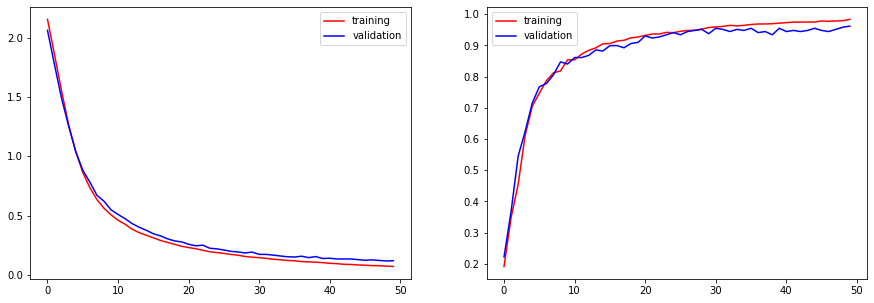

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [29]:
model.predict(X_test)

array([[3.4196306e-05, 9.7275606e-06, 8.3630192e-07, ..., 3.4044334e-15,
        4.0634492e-04, 4.5466711e-10],
       [4.9083222e-09, 2.1001615e-05, 4.8621828e-08, ..., 4.2711140e-06,
        3.4006322e-03, 9.6268356e-01],
       [4.1725754e-14, 2.2413183e-06, 1.2207361e-05, ..., 2.3046243e-09,
        1.6814964e-04, 4.3447269e-04],
       ...,
       [1.1585857e-01, 1.3892561e-03, 4.0271250e-03, ..., 8.5224643e-02,
        4.5874956e-01, 4.5933636e-04],
       [1.3821546e-09, 3.6581099e-05, 2.7255568e-04, ..., 3.8445268e-08,
        1.8971050e-02, 7.8641146e-02],
       [2.0281084e-12, 6.2402628e-06, 9.4853236e-09, ..., 5.0870100e-11,
        7.8220102e-05, 1.2172740e-02]], dtype=float32)

In [30]:
model.predict(X_test)[0]

array([3.4196306e-05, 9.7275606e-06, 8.3630192e-07, 5.4276644e-08,
       3.8234598e-06, 6.7626599e-05, 9.9947745e-01, 3.4044334e-15,
       4.0634492e-04, 4.5466711e-10], dtype=float32)

In [42]:
y_hat_test = np.argmax(model.predict(X_test), axis=1)

In [43]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 32,  0,  2],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 39]])

In [44]:
model.evaluate(X_test, y_test)[1]

12/12 [==============================] - 0s 592us/step - loss: 0.1613 - accuracy: 0.9583


0.9583333134651184

In [45]:
from sklearn.metrics import recall_score
recall_score(y_test_restore, y_hat_test, average='macro')

0.9570770416483809

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

